<a href="https://colab.research.google.com/github/Puja7890/js-youtube/blob/main/Copy_of_Untitled10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Price             Open        High         Low       Close   Adj Close  \
Date                                                                     
2020-10-26  114.010002  116.550003  112.879997  115.050003  111.911186   
2020-10-27  115.489998  117.279999  114.540001  116.599998  113.418892   
2020-10-28  115.050003  115.430000  111.099998  111.199997  108.166229   
2020-10-29  112.370003  116.930000  112.199997  115.320000  112.173820   
2020-10-30  111.059998  111.989998  107.720001  108.860001  105.890053   

Price          Volume  
Date                   
2020-10-26  111850700  
2020-10-27   92276800  
2020-10-28  143937800  
2020-10-29  146129200  
2020-10-30  190272600  
Creating features...
Training model...
Predicting on test set...
RMSE: 10.7713, MAE: 7.8161, MAPE: 3.35%


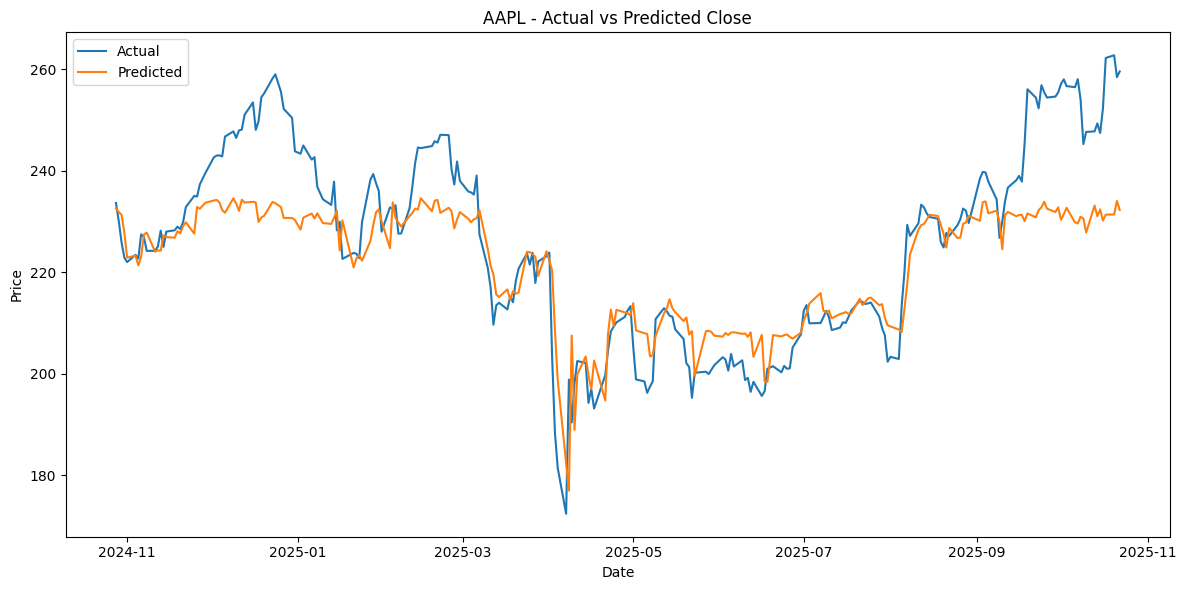

Model saved to model.joblib
Enter future date to predict (YYYY-MM-DD): 2026-01-25
Predicted Close for 2026-01-25: 231.2175
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c85186002a09d2ae2f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# ------------------------- Imports -------------------------
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

# ------------------------- Functions -------------------------
# Download historical stock data
def download_data(ticker: str, years: int = 5) -> pd.DataFrame:
    end = datetime.today()
    start = end - timedelta(days=365 * years)
    df = yf.download(
        ticker, start=start.strftime("%Y-%m-%d"), end=end.strftime("%Y-%m-%d"),
        progress=False, auto_adjust=False
    )
    # Flatten MultiIndex columns if any
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    # Keep necessary columns
    df = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].dropna()
    # Convert to numeric safely
    for col in ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.dropna()
    return df

# Create lag/rolling/momentum features
def create_features(df: pd.DataFrame, n_lags: int = 5) -> pd.DataFrame:
    df = df.copy()
    for lag in range(1, n_lags + 1):
        df[f'lag_{lag}'] = df['Close'].shift(lag)
    df['rolling_mean_7'] = df['Close'].rolling(7).mean()
    df['rolling_std_7'] = df['Close'].rolling(7).std()
    df['rolling_mean_21'] = df['Close'].rolling(21).mean()
    df['momentum_7'] = df['Close'] - df['Close'].shift(7)
    df['return_1'] = df['Close'].pct_change(1)
    df['return_5'] = df['Close'].pct_change(5)
    df['target'] = df['Close'].shift(-1)
    # Ensure numeric
    for col in df.columns:
        if col != 'Date':
            df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.dropna()
    return df

# Time-series train/test split
def train_test_split_time_series(df: pd.DataFrame, test_size: float = 0.2):
    n = len(df)
    split = int(n * (1 - test_size))
    train = df.iloc[:split]
    test = df.iloc[split:]
    return train, test

# Evaluate model
def evaluate(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return rmse, mae, mape

# Plot actual vs predicted
def plot_results(test_dates, y_true, y_pred, ticker):
    plt.figure(figsize=(12, 6))
    plt.plot(test_dates, y_true, label='Actual')
    plt.plot(test_dates, y_pred, label='Predicted')
    plt.title(f'{ticker} - Actual vs Predicted Close')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Recursive future prediction
def predict_future(model, data, feature_cols, start_date, end_date):
    last_row = data.loc[start_date].copy().astype(float)
    predictions = {}
    current_date = start_date + timedelta(days=1)

    while current_date <= end_date:
        feature_row = last_row[feature_cols].values.reshape(1, -1)
        pred_close = float(model.predict(feature_row)[0])
        predictions[current_date] = pred_close

        # Create new row with predicted Close
        new_row = last_row.copy()
        new_row['Close'] = pred_close

        # Update lag features
        for lag in range(1, 8):
            new_row[f'lag_{lag}'] = last_row['Close'] if lag == 1 else last_row.get(f'lag_{lag-1}', last_row['Close'])

        # Update rolling features
        last_7 = list(data['Close'].iloc[-6:].astype(float)) + [pred_close] if len(data) >= 6 else list(data['Close'].iloc[-len(data):].astype(float)) + [pred_close]
        new_row['rolling_mean_7'] = sum(last_7)/len(last_7)
        new_row['rolling_std_7'] = pd.Series(last_7).std()

        last_21 = list(data['Close'].iloc[-20:].astype(float)) + [pred_close] if len(data) >= 20 else list(data['Close'].iloc[-len(data):].astype(float)) + [pred_close]
        new_row['rolling_mean_21'] = sum(last_21)/len(last_21)

        # Momentum & returns
        new_row['momentum_7'] = new_row['Close'] - float(data['Close'].iloc[-7]) if len(data) >= 7 else 0.0
        new_row['return_1'] = (new_row['Close'] - last_row['Close']) / last_row['Close'] if last_row['Close'] != 0 else 0.0
        new_row['return_5'] = (new_row['Close'] - float(data['Close'].iloc[-5])) / float(data['Close'].iloc[-5]) if len(data) >= 5 else 0.0

        # Append new row
        data = pd.concat([data, pd.DataFrame([new_row], index=[current_date])])
        last_row = data.loc[current_date].astype(float)
        current_date += timedelta(days=1)

    return predictions

# ------------------------- Main Execution -------------------------
ticker = 'AAPL'
years = 5
model_out = 'model.joblib'

print(f"Downloading {ticker} data for last {years} years...")
df = download_data(ticker, years)
print(df.head())

print("Creating features...")
data = create_features(df, n_lags=7)
feature_cols = [c for c in data.columns if c not in ['target']]

train, test = train_test_split_time_series(data)
X_train, y_train = train[feature_cols], train['target']
X_test, y_test = test[feature_cols], test['target']

print("Training model...")
model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)
model.fit(X_train, y_train)

print("Predicting on test set...")
preds = model.predict(X_test)
rmse, mae, mape = evaluate(y_test.values, preds)
print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")

plot_results(test.index, y_test.values, preds, ticker)

joblib.dump({'model': model, 'features': feature_cols}, model_out)
print(f"Model saved to {model_out}")

# ------------------------- Predict Future -------------------------
future_input = input("Enter future date to predict (YYYY-MM-DD): ")
future_date = pd.to_datetime(future_input)
last_date_in_data = data.index.max()

if future_date <= last_date_in_data:
    feature_row = data.loc[future_date, feature_cols].values.reshape(1, -1)
    predicted_close = float(model.predict(feature_row)[0])
    print(f"Predicted Close for {future_date.date()}: {predicted_close:.4f}")
else:
    future_preds = predict_future(model, data.copy(), feature_cols, last_date_in_data, future_date)
    print(f"Predicted Close for {future_date.date()}: {future_preds[future_date]:.4f}")
    # ------------------------- Imports -------------------------

import gradio as gr

import matplotlib.pyplot as plt

import pandas as pd

from datetime import datetime

import joblib

import numpy as np

# ------------------------- Load trained model -------------------------

model_data = joblib.load("model.joblib")

model = model_data['model']

feature_cols = model_data['features']

# Assume 'data' and 'y_test' from previous code exist (from your training script)

# ------------------------- Prediction function -------------------------

def predict_stock(pred_date):

    pred_date = pd.to_datetime(pred_date)

    last_date_in_data = data.index.max()

    # Evaluate historical predictions first

    preds = model.predict(data[feature_cols])

    rmse, mae, mape = np.sqrt(((data['target'] - preds)**2).mean()), np.mean(np.abs(data['target'] - preds)), np.mean(np.abs((data['target'] - preds)/data['target']))*100

    # Future prediction

    if pred_date <= last_date_in_data:

        feature_row = data.loc[pred_date, feature_cols].values.reshape(1, -1)

        predicted_close = float(model.predict(feature_row)[0])

    else:

        from datetime import timedelta

        # Recursive prediction function

        def predict_future(model, data, feature_cols, start_date, end_date):

            last_row = data.loc[start_date].copy().astype(float)

            current_date = start_date + timedelta(days=1)

            predictions = {}

            while current_date <= end_date:

                feature_row = last_row[feature_cols].values.reshape(1, -1)

                pred_close = float(model.predict(feature_row)[0])

                predictions[current_date] = pred_close

                # Create new row with predicted Close

                new_row = last_row.copy()

                new_row['Close'] = pred_close

                for lag in range(1, 8):

                    new_row[f'lag_{lag}'] = last_row['Close'] if lag == 1 else last_row.get(f'lag_{lag-1}', last_row['Close'])

                # Rolling mean/std

                last_7 = list(data['Close'].iloc[-6:].astype(float)) + [pred_close] if len(data) >= 6 else list(data['Close'].iloc[-len(data):].astype(float)) + [pred_close]

                new_row['rolling_mean_7'] = sum(last_7)/len(last_7)

                new_row['rolling_std_7'] = pd.Series(last_7).std()

                last_21 = list(data['Close'].iloc[-20:].astype(float)) + [pred_close] if len(data) >= 20 else list(data['Close'].iloc[-len(data):].astype(float)) + [pred_close]

                new_row['rolling_mean_21'] = sum(last_21)/len(last_21)

                new_row['momentum_7'] = new_row['Close'] - float(data['Close'].iloc[-7]) if len(data) >= 7 else 0.0

                new_row['return_1'] = (new_row['Close'] - last_row['Close']) / last_row['Close'] if last_row['Close'] != 0 else 0.0

                new_row['return_5'] = (new_row['Close'] - float(data['Close'].iloc[-5])) / float(data['Close'].iloc[-5]) if len(data) >= 5 else 0.0

                data = pd.concat([data, pd.DataFrame([new_row], index=[current_date])])

                last_row = data.loc[current_date].astype(float)

                current_date += timedelta(days=1)

            return predictions

        future_preds = predict_future(model, data.copy(), feature_cols, last_date_in_data, pred_date)

        predicted_close = future_preds[pred_date]

    # Plot actual vs predicted

    plt.figure(figsize=(10,5))

    plt.plot(data.index, data['target'], label='Actual')

    plt.plot(data.index, preds, label='Predicted')

    plt.title('Actual vs Predicted Close')

    plt.xlabel('Date')

    plt.ylabel('Close Price')

    plt.legend()

    plt.tight_layout()

    plt.savefig("plot.png")

    plt.close()

    return f"${predicted_close:.2f}", f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%", "plot.png"

# ------------------------- Gradio UI -------------------------

iface = gr.Interface(

    fn=predict_stock,

    inputs=gr.Textbox(label="Enter Prediction Date (YYYY-MM-DD)"),

    outputs=[gr.Textbox(label="Predicted Close"), gr.Textbox(label="Evaluation Metrics"), gr.Image(label="Prediction Graph")],

    title="Stock Price Prediction",

    description="Enter a date to predict stock price. The model shows predicted close, evaluation scores, and graph."

)

iface.launch()


import sys

!{sys.executable} -m pip install Joblib yfinance pandas scikit-learn matplotlib xgboost gradio

